In [1]:
from pathlib import Path
import re
import pickle
from collections import defaultdict
import numpy as np 
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union

# Style for Matplotlib
import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])


In [2]:
c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10

In [3]:
REG_RE = re.compile(r"(?:^|[+_])reg([^+_]+)")
# rnn counted if:
#   - appears as a token: (^|[+_])rnn($|[+_])
#   - OR appears at end of string: ...rnn
RNN_RE = re.compile(r"(?:^|[+_])rnn(?:$|[+_])|rnn$")

KeyT = Tuple[str, bool]  # (reg_val, has_rnn)

def group_files_by_reg_and_rnn(dir_path: Union[str, Path]) -> Dict[KeyT, List[Path]]:
    dir_path = Path(dir_path)
    groups: Dict[KeyT, List[Path]] = defaultdict(list)

    for p in dir_path.iterdir():
        if not p.is_file():
            continue

        m = REG_RE.search(p.name)
        if m is None:
            continue  # skip files without reg...

        reg_val = m.group(1)
        has_rnn = bool(RNN_RE.search(p.stem))  # use stem to ignore extensions

        groups[(reg_val, has_rnn)].append(p)

    for k in groups:
        groups[k].sort(key=lambda x: x.name)

    return dict(groups)


In [4]:
groups = group_files_by_reg_and_rnn("./twotasks_data")

# all keys (unsorted)
all_keys = list(groups.keys())

# nicer: sorted keys
all_keys_sorted = sorted(all_keys, key=lambda k: (k[0], k[1]))
print(type(all_keys_sorted[0]))

print("All keys:")
for reg_val, has_rnn in all_keys_sorted:
    print(f"reg={reg_val}\trnn={has_rnn}\tn_files={len(groups[(reg_val, has_rnn)])}")


<class 'tuple'>
All keys:
reg=1e3	rnn=False	n_files=5
reg=1e8	rnn=False	n_files=3
reg=1e8	rnn=True	n_files=1


In [5]:
keys = [
        ["1e-8", "1e8", False], 
        ["1e-3", "1e3", False], 
        ["1e-8", "1e8", True],
        # ["1e-3", "1e3", True]
]

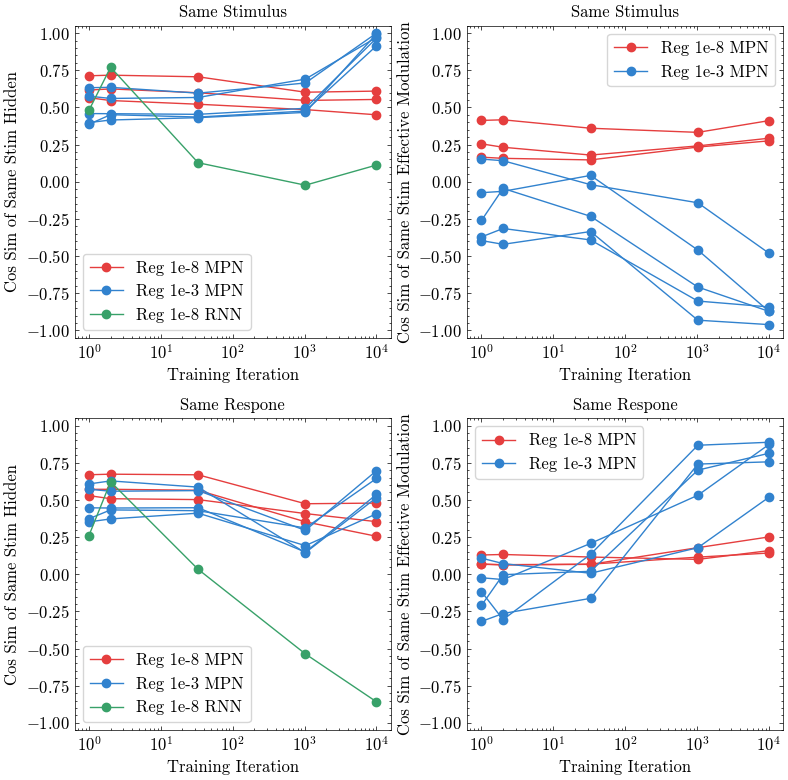

In [6]:
fig, axs = plt.subplots(2,2,figsize=(4*2,4*2))

same_groups = ["Same Stimulus", "Same Respone"]

for i, same_group in enumerate(same_groups): 
    for idx, (value_name, value, hasrnn) in enumerate(keys):
        files = groups[(value, hasrnn)]
        for file_idx, file in enumerate(files):
            with open(file, "rb") as f:
                obj = pickle.load(f)  
            counter_lst = obj["learning_hm_similarity"]["counter_lst"]
            same_stim_h = obj["learning_hm_similarity"]["result_attractor_all_h"]
            same_stim_h_mean = [same_stim_h_[i][0] for same_stim_h_ in same_stim_h]
            name = f"Reg {value_name}" if file_idx == 0 else None
            if name is not None: 
                name += " RNN" if hasrnn else " MPN"
            axs[i,0].plot(counter_lst, same_stim_h_mean, "-o", c=c_vals[idx], label=name)
            if hasrnn == False:  # only plot for MPN
                same_stim_wm = obj["learning_hm_similarity"]["result_attractor_all_wmwin"]
                same_stim_wm_mean = [same_stim_wm_[i][0] for same_stim_wm_ in same_stim_wm]
                axs[i,1].plot(counter_lst, same_stim_wm_mean, "-o", c=c_vals[idx], label=name)
            axs[i,0].set_title(same_group, fontsize=12)
            axs[i,1].set_title(same_group, fontsize=12)

for ax in axs.flatten():
    ax.set_xscale("log")
    ax.set_xlabel("Training Iteration", fontsize=12)
    ax.tick_params(axis="both", which="both", labelsize=12)
    ax.legend(fontsize=12, frameon=True)
    ax.set_ylim([-1.05, 1.05])

for i in range(2): 
    axs[i,0].set_ylabel("Cos Sim of Same Stim Hidden", fontsize=12)
    axs[i,1].set_ylabel("Cos Sim of Same Stim Effective Modulation", fontsize=12)

fig.tight_layout()

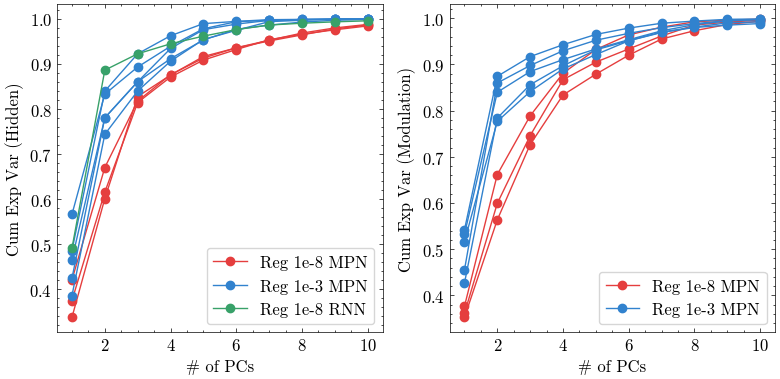

In [7]:
pc_names = ["hidden_task0_resp", "modulation_task0_resp"]

fig, axs = plt.subplots(1,2,figsize=(4*2,4))
for pc_idx, pc_name in enumerate(pc_names): 
    for idx, (value_name, value, hasrnn) in enumerate(keys):
        if not (hasrnn and pc_idx == 1): 
            files = groups[(value, hasrnn)]
            for file_idx, file in enumerate(files):
                with open(file, "rb") as f:
                    obj = pickle.load(f)  
                pcs = obj["pcs"]
                resp = pcs[pc_name]
                name = f"Reg {value_name}" if file_idx == 0 else None
                if name is not None: 
                    name += " RNN" if hasrnn else " MPN"
                axs[pc_idx].plot([i+1 for i in range(len(resp))], resp, "-o", 
                                 color=c_vals[idx], label=name if file_idx == 0 else None)

for ax in axs:
    ax.set_xlabel("# of PCs", fontsize=12)
    ax.legend(fontsize=12, frameon=True)
    ax.tick_params(axis="both", which="both", labelsize=12)
    
axs[0].set_ylabel("Cum Exp Var (Hidden)", fontsize=12)
axs[1].set_ylabel("Cum Exp Var (Modulation)", fontsize=12)
fig.tight_layout()